# News Title Classification

## Objective

Make a classifier to classify news title. There are 4 categories:
* Business 
* Entertainment
* Medical
* Technology.

## Table of Contents
**1. Load and Check Data**

    1.1 Importing Data
    1.2 Remove Non-title Text
    1.3 Remove duplicate
    1.4 Normalize Title

**2. Data Exploration**

    2.1 Check Distribution
**3. Data Modelling & Prediction**

    3.1 Logistic Regression
        - 3.1.1 Prediction
        - 3.1.2 Confusion Matrix
    3.2 Multinomial Naive Bayes
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.3 Random Forest Classifier
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.4 Stochastic Gradient Descent
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.5 Summary
**4. Conclusion**

## 1. Load and Check Data

### 1.1 Importing Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_excel('data/01_raw/News Title.xls', index_col = 0)

df.head()

,News Title,Category
No,,
1,Google+ rolls out 'Stories' for tricked out ph...,Technology
2,Dov Charney's Redeeming Quality,Business
3,White God adds Un Certain Regard to the Palm Dog,Entertainment
4,"Google shows off Androids for wearables, cars,...",Technology
5,China May new bank loans at 870.8 bln yuan,Business


### 1.2 Remove Non-Title Text

In [4]:
# copy the original, to be safe
df_clean = df.copy()

In [5]:
df_clean.groupby('Category').describe()

News Title         \
                   count unique   
Category                          
Business           17707  17557   
Entertainment      23961  23774   
Medical             7091   7042   
Technology         16776  16666   

                                                                       
                                                             top freq  
Category                                                               
Business                     Posted by Shoaib-ur-Rehman Siddiqui   10  
Entertainment  The article requested cannot be found! Please ...   20  
Medical        'Young' blood injections help aging mice get s...    3  
Technology                                         Business Wire    5

In [6]:
df_clean['News Title'].value_counts()[df_clean['News Title'].value_counts() > 1].head(10)

The article requested cannot be found! Please refresh your browser or go back  ...    21
Posted by Shoaib-ur-Rehman Siddiqui                                                   11
Posted by Imaduddin                                                                   11
Posted by Parvez Jabri                                                                10
Business Highlights                                                                   10
(click the phrases to see a list)                                                      7
Business Wire                                                                          7
What you need to know before markets open                                              7
10 Things to Know for Today                                                            6
PR Newswire                                                                            6
Name: News Title, dtype: int64

In [7]:
#remove news title text contains article requested cannot be found
df_clean = df_clean.drop(df_clean[df_clean['News Title'].str.contains('article requested cannot be found')].index)

In [8]:
#remove news title text contains Posted by
df_clean = df_clean.drop(df_clean[df_clean['News Title'].str.contains('Posted by')].index)

In [9]:
#remove news title text contains PR Newswire
df_clean = df_clean.drop(df_clean[df_clean['News Title'].str.contains('PR Newswire')].index)

In [10]:
#remove news title text contains Business wire
df_clean = df_clean.drop(df_clean[df_clean['News Title'].str.contains('Business Wire')].index)

In [11]:
#remove news title text contains click the phrases to see a list
df_clean = df_clean.drop(df_clean[df_clean['News Title'].str.contains('click the phrases to see a list')].index)

In [12]:
#remove news title text contains Share this on:
df_clean = df_clean.drop(df_clean[df_clean['News Title'].str.contains('Share this on:')].index)

In [13]:
df_clean['News Title'].value_counts()[df_clean['News Title'].value_counts() > 1].head(10)

Business Highlights                          10
What you need to know before markets open     7
10 Things to Know for Today                   6
The Daily Dish                                5
India Morning Call-Global Markets             5
Business briefs                               5
Change text size for the story                5
Perez Recommends                              4
Most Popular Stories                          4
Sara Stewart                                  4
Name: News Title, dtype: int64

### 1.3 Check duplicates

In [14]:
df_clean.groupby('Category').describe()

News Title         \
                   count unique   
Category                          
Business           17665  17547   
Entertainment      23937  23770   
Medical             7086   7039   
Technology         16761  16659   

                                                                       
                                                             top freq  
Category                                                               
Business                                     Business Highlights    8  
Entertainment                                     The Daily Dish    5  
Medical        'Young' blood injections help aging mice get s...    3  
Technology                  Nokia to be renamed Microsoft Mobile    3

**There are some duplicate entries for each Category, 150 for Business, 187 for Entertainment, 49 for Medical and 110 for Technology. Let's remove them by category**

In [15]:
business = df_clean[df_clean['Category'] == 'Business'].copy()
entertainment = df_clean[df_clean['Category'] == 'Entertainment'].copy()
medical = df_clean[df_clean['Category'] == 'Medical'].copy()
technology = df_clean[df_clean['Category'] == 'Technology'].copy()

frames = [business, entertainment, medical, technology]

In [16]:
#remove duplicate for each category
for frame in frames:
    frame.drop_duplicates(subset='News Title', inplace=True)

In [17]:
df_clean = pd.concat(frames)
df_clean.groupby('Category').describe()

News Title         \
                   count unique   
Category                          
Business           17547  17547   
Entertainment      23770  23770   
Medical             7039   7039   
Technology         16659  16659   

                                                                       
                                                             top freq  
Category                                                               
Business       Forex - USD/CAD remains rangebound after U.S. ...    1  
Entertainment   VIDEO: Mother Bear Grabs Cub Off Busy BC Highway    1  
Medical        Infusion of young blood recharges brains of ol...    1  
Technology     Samsung launches the ultra-thin Galaxy Tab S a...    1

**duplicates have been removed**

### 1.4 Normalize Title

* Lowercase all words
* convert shortform into long form
* remove punctuations and symbols

In [45]:
# Lowercase all words
df_clean['News Title'] = df_clean['News Title'].apply(lambda x: x.lower())

In [46]:
# Dictionary of short form words and mispellings
short_forms_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                    "'cause": "because", "could've": "could have", "couldn't": "could not", 
                    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                    "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                    "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                    "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                    "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                    "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                    "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                    "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                    "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", 
                    "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                    "you're": "you are", "you've": "you have"}

In [48]:
import re

def clean_shortforms(text):
    clean_text = text
    for shortform in short_forms_dict.keys():
        if re.search(shortform, text):
            clean_text = re.sub(shortform, short_forms_dict[shortform], text)
    return clean_text

# fix short forms
df_clean['News Title'] = df_clean['News Title'].apply(lambda x: clean_shortforms(x))

In [49]:
symbols = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', 
           ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', 
           '#', '*', '+', '\\', '•',  '~', '@', '£', '·', '_', 
           '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', 
           '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
           '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', 
           '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', 
           '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', 
           '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', 
           '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', 
           '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', 
           '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', 
           '¹', '≤', '‡', '√', ]

In [50]:
def clean_symbol(text):
    text = str(text)
    for symbol in symbols:
        text = text.replace(symbol, '')
    return text

# remove symbols and punctuations 
df_clean['News Title'] = df_clean['News Title'].apply(lambda x: clean_symbol(x))

In [18]:
# save into csv
df_clean.to_csv('data/02_intermediate/cleaned_data.csv')

## 2. Data Exploration

### 2.1 Check the Distribution

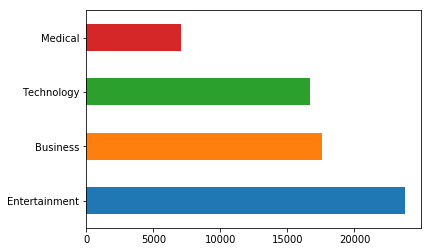

In [51]:
df_clean['Category'].value_counts().plot(kind='barh');

**Most samples belongs to Entertainment Category. A sizable number of samples belongs to Technology and Business Category. about 10%-11% belonged to strongly Medical Category**

## 3. Data Modelling & Prediction

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report

# suppress bs4 warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [53]:
x_train, x_test, y_train, y_test = train_test_split(df_clean['News Title'], df_clean['Category'], test_size=0.2)

x_train.to_csv('data/03_processed/x_train.csv', header=False)
y_train.to_csv('data/03_processed/y_train.csv', header=False)
x_test.to_csv('data/03_processed/x_test.csv', header=False)
y_test.to_csv('data/03_processed/y_test.csv', header=False)

### 3.1 Logistic Regression

In [54]:
reglog_pipe = Pipeline([
    ('bow', CountVectorizer(stop_words='english')), # strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(solver='liblinear', multi_class='auto')) # train on TF-IDF vectors w/ SGD classifier
])

reglog_pipe.fit(x_train, y_train);

#### 3.1.1 Prediction

In [55]:
reglog_predictions = reglog_pipe.predict(x_test);

In [56]:
reglog_report = classification_report(y_test, reglog_predictions)
print(reglog_report)

               precision    recall  f1-score   support

     Business       0.89      0.89      0.89      3506
Entertainment       0.92      0.98      0.95      4841
      Medical       0.95      0.80      0.87      1351
   Technology       0.90      0.88      0.89      3305

    micro avg       0.91      0.91      0.91     13003
    macro avg       0.92      0.89      0.90     13003
 weighted avg       0.91      0.91      0.91     13003



#### 3.1.2 Confusion Matrix

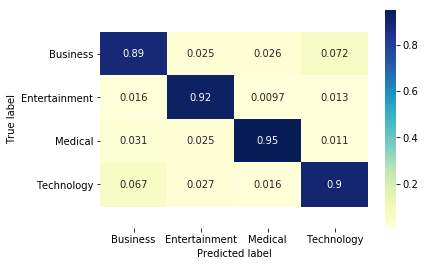

In [57]:
cm = confusion_matrix(y_test, reglog_predictions)

cm = cm/cm.astype(np.float).sum(axis=0)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Business','Entertainment', 'Medical', 'Technology'], 
                     columns = ['Business','Entertainment', 'Medical', 'Technology'])

ax = sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 3.2 Multinomial Naive Bayes

In [58]:
nb_pipe = Pipeline([
    ('bow', CountVectorizer(stop_words='english')), # strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

nb_pipe.fit(x_train, y_train)
nb_train_score = nb_pipe.score(x_train, y_train)
nb_test_score = nb_pipe.score(x_test, y_test)

#### 3.2.1 Prediction

In [59]:
nb_predictions = nb_pipe.predict(x_test);

In [60]:
nb_report = classification_report(y_test, nb_predictions)
print(nb_report)

               precision    recall  f1-score   support

     Business       0.87      0.89      0.88      3506
Entertainment       0.92      0.97      0.95      4841
      Medical       0.98      0.73      0.83      1351
   Technology       0.89      0.88      0.88      3305

    micro avg       0.90      0.90      0.90     13003
    macro avg       0.91      0.87      0.89     13003
 weighted avg       0.90      0.90      0.90     13003



#### 3.2.2 Confusion Matrix

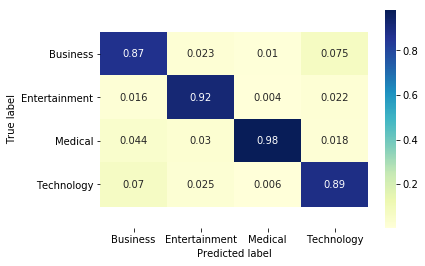

In [61]:
cm = confusion_matrix(y_test, nb_predictions)

cm = cm/cm.astype(np.float).sum(axis=0)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Business','Entertainment', 'Medical', 'Technology'], 
                     columns = ['Business','Entertainment', 'Medical', 'Technology'])

ax = sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 3.3 Random Forest Classifier

In [62]:
rf_pipe = Pipeline([
    ('bow', CountVectorizer(stop_words='english')), # strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()) # train on TF-IDF vectors w/ Random Forest classifier
])

rf_pipe.fit(x_train, y_train);

C:\Users\BPS\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### 3.3.1 Prediction

In [63]:
rf_predictions = rf_pipe.predict(x_test);


In [64]:
rf_report = classification_report(y_test, rf_predictions)
print(rf_report)

               precision    recall  f1-score   support

     Business       0.85      0.86      0.86      3506
Entertainment       0.88      0.95      0.91      4841
      Medical       0.90      0.77      0.83      1351
   Technology       0.90      0.83      0.86      3305

    micro avg       0.88      0.88      0.88     13003
    macro avg       0.88      0.85      0.86     13003
 weighted avg       0.88      0.88      0.88     13003



#### 3.3.2 Confusion Matrix

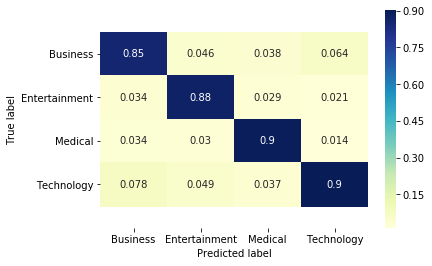

In [65]:
cm = confusion_matrix(y_test, rf_predictions)

cm = cm/cm.astype(np.float).sum(axis=0)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Business','Entertainment', 'Medical', 'Technology'], 
                     columns = ['Business','Entertainment', 'Medical', 'Technology'])

ax = sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 3.5 Summary

In [66]:
print('---------------------------------------')
print('Logistic Regression Result')
print('---------------------------------------')
print(reglog_report)
print()
print('---------------------------------------')
print('Naive Bayes Result')
print('---------------------------------------')
print(nb_report)
print()
print('---------------------------------------')
print('Random Forest Classification Result')
print('---------------------------------------')
print(rf_report)
print()

---------------------------------------
Logistic Regression Result
---------------------------------------
               precision    recall  f1-score   support

     Business       0.89      0.89      0.89      3506
Entertainment       0.92      0.98      0.95      4841
      Medical       0.95      0.80      0.87      1351
   Technology       0.90      0.88      0.89      3305

    micro avg       0.91      0.91      0.91     13003
    macro avg       0.92      0.89      0.90     13003
 weighted avg       0.91      0.91      0.91     13003


---------------------------------------
Naive Bayes Result
---------------------------------------
               precision    recall  f1-score   support

     Business       0.87      0.89      0.88      3506
Entertainment       0.92      0.97      0.95      4841
      Medical       0.98      0.73      0.83      1351
   Technology       0.89      0.88      0.88      3305

    micro avg       0.90      0.90      0.90     13003
    macro avg     

## 4. Conclusion
On average our models are about **90.75% accurate**. While this may mean that the machine cannot predict every comments with 100% accuracy. It can really depend on the data and how it has been processed.

Out of the 4 used in this project, the most **accurate and precise was the Logistic Regression**, with accuracy of 92%.

Logistic Regression **highest recall**, with recall score 89%. This means that the models actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive).

Logistic Regression has the **highest F1 score**, with f1 score 90%, which means that it defines a relationship between Recall and Precision of a particular model. F1 Scores might be a better measure to use if we need to seek a balance between Precision and Recall and if there is an uneven class distribution (a large number of Actual Negatives).

In [43]:
df_output = pd.DataFrame(x_test.copy())
df_output['Class'] = y_test
df_output['Prediction'] = reglog_predictions

In [44]:
df_output.to_csv('data/04_model_output/reglog_output.csv')